In [2]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [3]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [4]:
class UpDownUpHomoPentamer(specifications.CoiledCoil):
    """Specification for creating up-down-up, homopentameric coiled coils."""
    
    oligomeric_state = 5
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 3 helices, we have 3 values for each of these, but in this case they
        # are the same as we're making a homotrimer
        self.aas = [helix_length, helix_length, helix_length, helix_length, helix_length]
        self.major_radii = [radius, radius, radius, radius, radius]
        self.major_pitches = [pitch, pitch, pitch, pitch, pitch]
        #self.z_shifts = [0, zshift, zshift]
        self.phi_c_alphas = [phica, phica, phica, phica, phica]
        
        # We need to set the orientation of the helices
        self.orientations = [1, -1, 1, -1, 1] # up-down-up-down-up specification

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [5]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [6]:
sequences = ['GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY',
             'GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY']

In [7]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [8]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 8.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27)
]

In [9]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 8.0, 200, 154.2]


### Genetic Algorithm

In [10]:
opt_ga = ev_opts.GA(UpDownUpHomoPentamer, sequences, parameters, get_bude_total_energy)

In [11]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min    	max     
0  	67   	-2149.41	247.363	-2467.1	-1626.81
1  	72   	-2378.25	50.4856	-2480.88	-2241.04
2  	74   	-2419.84	27.5179	-2480.88	-2379.68
3  	71   	-2442.25	23.5848	-2480.88	-2405.52
4  	76   	-2465.22	10.2584	-2485.22	-2445.91
5  	70   	-2473.24	6.0786 	-2485.95	-2463.19
6  	72   	-2477.87	5.11676	-2486.49	-2468.73
7  	62   	-2482.07	3.54136	-2487.16	-2474.94
8  	73   	-2485.11	1.23264	-2487.87	-2482.75
9  	61   	-2485.96	0.880003	-2487.87	-2484.06
10 	81   	-2486.57	0.495774	-2487.87	-2485.54
11 	52   	-2486.88	0.484168	-2487.89	-2486.02
12 	73   	-2487.15	0.416209	-2488.14	-2486.44
13 	78   	-2487.49	0.278624	-2488.14	-2487.02
14 	67   	-2487.51	0.255283	-2488.14	-2487.06
15 	80   	-2487.59	0.255895	-2488.2 	-2487.17
16 	59   	-2487.65	0.237981	-2488.2 	-2487.26
17 	75   	-2487.78	0.208736	-2488.2 	-2487.44
18 	82   	-2487.88	0.177499	-2488.31	-2487.55
19 	62   	-2487.97	0.146225	-2488.31	-2487.67
20 	56   	-2488.02	0.119942	-2488.31	-2487.82


In [12]:
optimized_model_ga = opt_ga.best_model

In [13]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-2488.3998985923454

In [14]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [15]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

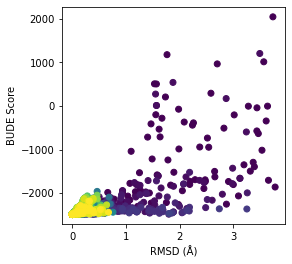

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('ga.png')

In [17]:
f = open('d_CC-Di_pentamer_ududu-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [18]:
opt_de = ev_opts.DE(UpDownUpHomoPentamer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [19]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-1775.11	540.926	-2446.23	3.88157
1  	100  	-2077.69	318.121	-2446.23	-881.279
2  	100  	-2238.03	185.287	-2467.37	-1727.92
3  	100  	-2329.14	109.974	-2477.59	-1925.95
4  	100  	-2389.74	47.5103	-2477.59	-2211.81
5  	100  	-2408.39	34.9643	-2477.59	-2317.95
6  	100  	-2420.5 	29.5972	-2477.59	-2350.88
7  	100  	-2432.47	26.7718	-2486.19	-2351.6 
8  	100  	-2440.63	22.8889	-2486.19	-2384.21
9  	100  	-2446.24	20.3126	-2486.19	-2384.48
10 	100  	-2451.28	16.7491	-2486.19	-2411.39
11 	100  	-2457.08	14.9506	-2489.97	-2417.88
12 	100  	-2460.81	14.1451	-2489.97	-2419.76
13 	100  	-2464.32	13.5107	-2494.07	-2419.76
14 	100  	-2468.01	10.8043	-2494.07	-2437.22
15 	100  	-2471.39	9.9712 	-2496.67	-2437.22
16 	100  	-2473.75	8.15644	-2496.67	-2452.62
17 	100  	-2475.34	8.14032	-2496.67	-2452.62
18 	100  	-2477.18	8.24626	-2496.67	-2452.62
19 	100  	-2479.21	7.62228	-2496.67	-2459.42
20 	100  	-2480.57	7.01969	-2496.67	-2461.96
21 	100  	-2

In [20]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-2497.8563067151276

In [21]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [22]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

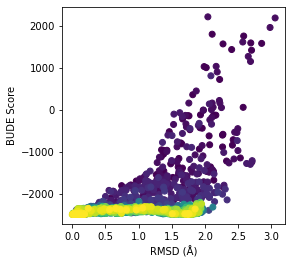

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('de.png')

In [24]:
f = open('d_CC-Di_pentamer_ududu-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [25]:
opt_pso = ev_opts.PSO(UpDownUpHomoPentamer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [26]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std   	min     	max     
0  	100  	-2022.34	365.37	-2454.59	-384.435
1  	78   	-2238.88	262.258	-2457.73	-971.809
2  	32   	-2272.97	214.318	-2467.07	-1090.21
3  	56   	-2186.99	245.682	-2467.07	-1090.21
4  	86   	-2000.73	398.34 	-2464.74	-36.5693
5  	88   	-1646.88	588.404	-2458.5 	181.413 
6  	88   	-2244.08	221.132	-2460.29	-1277.43
7  	63   	-2253.49	219.302	-2468.56	-1277.43
8  	54   	-2202.91	312.027	-2468.56	-139.205
9  	79   	-2089.39	341.198	-2444.32	-73.4231
10 	89   	-1732.39	501.205	-2470.7 	247.117 
11 	67   	-1941.36	459.42 	-2480.45	4.31756 
12 	84   	-2070.54	476.549	-2480.45	39.2028 
13 	80   	-2040.14	431.098	-2448.68	1026.57 
14 	80   	-2003.1 	335.232	-2428.67	-405.825
15 	43   	-2037.2 	312.932	-2469.17	-405.825
16 	50   	-2184.66	214.235	-2469.17	-1319.65
17 	64   	-2213.36	235.971	-2469.17	-1152.04
18 	71   	-2180.87	231.789	-2463.78	-1308.98
19 	69   	-2156.54	309.269	-2460.31	-558.457
20 	75   	-2144.92	267.656	-2460.17	-1056.01
21 	85   	-1

In [27]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-2498.1201623918564

In [28]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [29]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

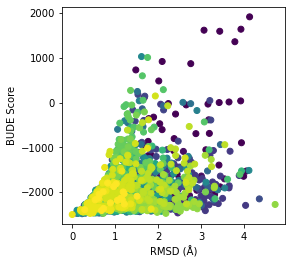

In [30]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('pso.png')

In [31]:
f = open('d_CC-Di_pentamer_ududu-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [32]:
opt_cmaes = ev_opts.CMAES(UpDownUpHomoPentamer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [33]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg  	std    	min     	max    
0  	100  	-1500	487.975	-2272.54	697.741
1  	100  	-1653.88	750.029	-2424.2 	616.363
2  	100  	-1890.68	767.606	-2462.1 	1590.42
3  	100  	-2304.45	162.98 	-2479.46	-1559.3
4  	100  	-2387.04	40.0903	-2475.15	-2221.64
5  	100  	-2401.96	50.6451	-2481.64	-2170.46
6  	100  	-2416.19	39.661 	-2478.58	-2271.08
7  	100  	-2438.67	25.6657	-2486.78	-2374.4 
8  	100  	-2437.53	27.5192	-2485.62	-2358.75
9  	100  	-2462.67	15.7751	-2486.3 	-2417.95
10 	100  	-2471.44	7.74637	-2484.94	-2440.86
11 	100  	-2475.6 	8.24784	-2484.62	-2425.34
12 	100  	-2476.57	8.09153	-2487.75	-2445.12
13 	100  	-2473.88	14.5517	-2488.96	-2396.02
14 	100  	-2476.1 	13.7146	-2488.64	-2428.16
15 	100  	-2482.22	6.68599	-2488.47	-2452.65
16 	100  	-2479.05	13.2543	-2488.81	-2440.29
17 	100  	-2479.37	12.9889	-2489.61	-2435.85
18 	100  	-2483.9 	7.88325	-2489.15	-2451.21
19 	100  	-2481.03	11.4577	-2489.56	-2451.32
20 	100  	-2478.51	12.4064	-2489.32	-2437.28
21 	100  	-2483.48	7.

In [34]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-2490.0182272198663

In [35]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [36]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

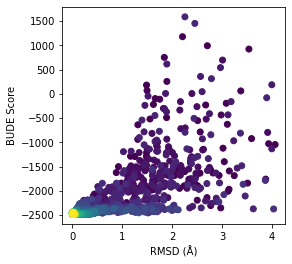

In [37]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('cmaes.png')

In [38]:
f = open('d_CC-Di_pentamer_ududu-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)